# Using NBC, KNN, and Ensemble Learning to predict the likelihood of disease 

                                                                                         Tanya Naheta

## Executive Summary

This report provides an anaylsis and evaluation of the likelihood of a person getting a certain unspecified disease. A variety of methods will be used to come up with this conclusion such as NBC, KNN, Random forest and Gradient boosting machine. I investigated the aforementioned algorithms, fine tuned them to the provided data set and provided accuracy results using the training data set. The results from this report show that Random forest was the most succesful algorithm at identifying whether or not a person has a disease followed closely by the Gradient boosting machine. In doing the analysis of the provided data, I also discovered that blood pressure, cholesterol, age and weight are highly correlated to the likelihood of having a disease meaning those were the most important features for this analysis.

## Introduction

Predicting whether or not a person has a disease can seem very daunting given that it likely depends on a variety of factors. However, if we were to isolate a few key factors and characteristics of a person, we could likely build a model that accurately predicts whether or not a person has some unspecified disease. This report will dive deeper into this exploration and try to highlight the key variables that closely correlate to the likelihood of a disease.

These are the attributes available to us in the dataset:
* Age: in years
* Gender: male/female
* Height: in unit of cm
* Weight: in unit of kg
* Low Blood Pressure: lower bound of blood pressure measurement
* High Blood Pressure: higher bound of blood pressure measurement
* Cholesterol: three cholesteral levels
* Glucose: three glucose levels
* Smoke: 1/0 regarding if the patient smokes
* Alcohol: 1/0 regarding if the patient drinks alcohol
* Exercise: 1/0 regarding if the patient exercises regularly
* Disease: Binary target variable

The goal of this anaylsis is to be able to accurately predict the disease target variable given the attributes provided to our algorithms.

## Data Preparation

In [437]:
import numpy as np 
import pandas as pd 

# importing the training data set csv file
df = pd.read_csv('DiseasePredictionTraining.csv')
# print information about the imported data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49000 entries, 0 to 48999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  49000 non-null  int64  
 1   Gender               49000 non-null  object 
 2   Height               49000 non-null  int64  
 3   Weight               49000 non-null  float64
 4   High Blood Pressure  49000 non-null  int64  
 5   Low Blood Pressure   49000 non-null  int64  
 6   Cholesterol          49000 non-null  object 
 7   Glucose              49000 non-null  object 
 8   Smoke                49000 non-null  int64  
 9   Alcohol              49000 non-null  int64  
 10  Exercise             49000 non-null  int64  
 11  Disease              49000 non-null  int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 4.5+ MB


In [438]:
# checking for missing any values
df.count().sort_values()

Age                    49000
Gender                 49000
Height                 49000
Weight                 49000
High Blood Pressure    49000
Low Blood Pressure     49000
Cholesterol            49000
Glucose                49000
Smoke                  49000
Alcohol                49000
Exercise               49000
Disease                49000
dtype: int64

From the imported data set, we can see that we have 11 attribute columns, giving us a total of 49,000 data points to analyze. As expected, Gender, Cholesterol and Glucose are string variables so we can convert those to numerical attributes for easier anaylsis. We can replace them in the dataset as shown below. 

In [439]:
# converting Gender, Cholesterol and Glucose columns to numerical attributes since they are the only categorical attributes
df['Gender'].replace({'male': 0, 'female': 1},inplace = True)
df['Cholesterol'].replace({'normal': 0, 'high': 1, 'too high': 2},inplace = True)
df['Glucose'].replace({'normal': 0, 'high': 1, 'too high': 2},inplace = True)

# print data set rows to ensure they were successfully altered
df[0:5]

,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease
0,59,1,167,88.0,130,68,0,0,0,0,1,0
1,64,1,150,71.0,140,100,0,0,0,0,0,1
2,41,1,166,83.0,100,70,0,0,0,1,1,0
3,50,0,172,110.0,130,80,0,0,1,0,1,0
4,39,1,162,61.0,110,80,1,1,0,0,1,0


Once we have all our data in the correct format and have removed any missing values (luckily, we didn't have to do this), we need to ensure that the target variable is equally balanced otherwise it could skew the model. We plotted the counts of the binary disease variable below and they are similar in number, which means we can use the training data set as is to train our models.

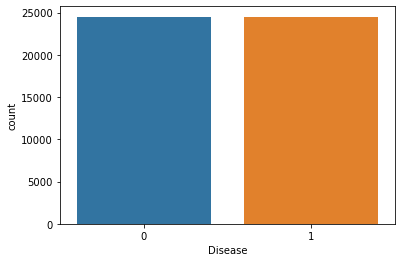

In [440]:
# check to see the distribution of the target variable (Disease)
import seaborn as sns

sns.countplot(df['Disease'])

Now that we have ensured that we have an equal split of the target variable in the training data set, we need to analyze the other attributes available to us to see whether or not we need to do any cleaning there. We will plot a box and whisker plot for all the attributes in the data. From the plot below, we can see that the most alarming discrepancies are in the blood pressure columns that could mislead our model. We will need to clean both of these attributes in order to build a more accurate model.

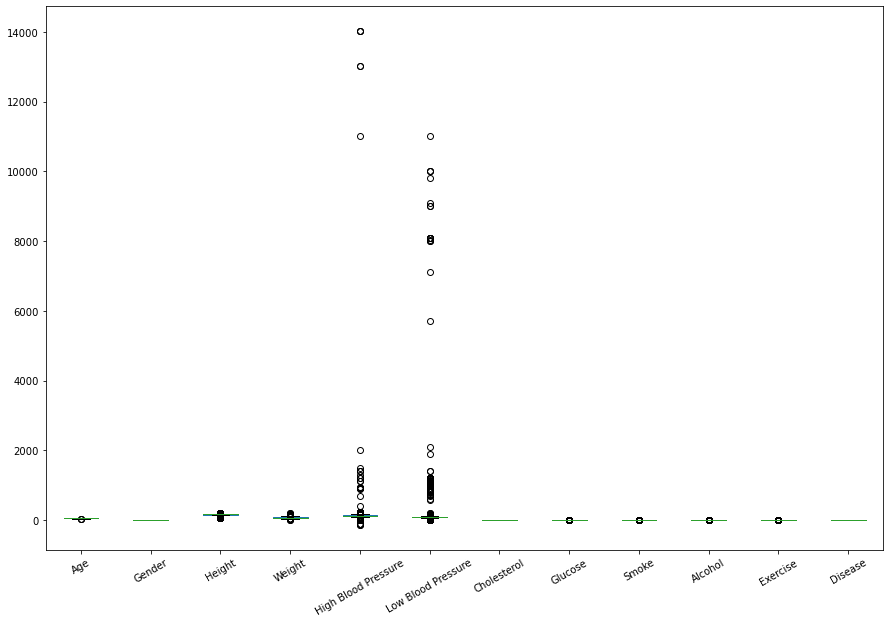

In [441]:
# plots to see the distribution of the data
df.boxplot(grid=False, rot=30, fontsize=10, figsize=(15,10))

While the box and whisker plot above is alarming for the two blood pressure columns, we can quite easily get rid of the extreme outliers in these columns by only keeping values within certain percentiles. After experimenting with quite a few different thresholds, I settled on keeping the lower bound as the 10th percentile and the upper bound as the 95th percentile. These thresholds provided the most reliable and realistic set of values for the blood pressure.

In order to remove the outliers, we can calculate the values on the respective quantiles, and then remove any rows from the data set that don't fall within this. We can also see the new box and whisker plots for both the blood pressure columns and they look more realistic.

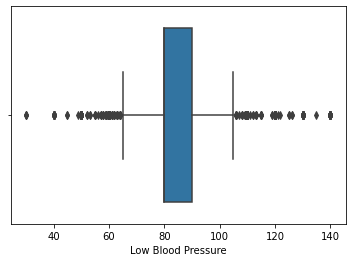

In [442]:
# removing the *extreme* outliers from the low blood pressure column
LowerPercentile = df['Low Blood Pressure'].quantile(0.1)
UpperPercentile = df['Low Blood Pressure'].quantile(0.95)
Range = UpperPercentile - LowerPercentile

filter = (df['Low Blood Pressure'] >= LowerPercentile - 1.5 * Range) & (df['Low Blood Pressure'] <= UpperPercentile + 1.5 * Range)
df = df.loc[filter]

sns.boxplot(df['Low Blood Pressure'])

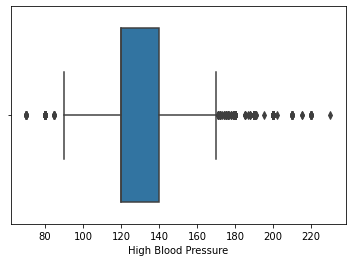

In [443]:
# removing the *extreme* outliers from the high blood pressure column
LowerPercentile = df['High Blood Pressure'].quantile(0.1)
UpperPercentile = df['High Blood Pressure'].quantile(0.95)
Range = UpperPercentile - LowerPercentile

filteredValues = (df['High Blood Pressure'] >= LowerPercentile - 1.5 * Range) & (df['High Blood Pressure'] <= UpperPercentile + 1.5 * Range)
df = df.loc[filteredValues]

sns.boxplot(df['High Blood Pressure'])

After cleaning up the blood pressure columns, we can plot the graph above again and it looks much cleaner now. The other columns that could have been cleaned up were Age, Height and Weight but even the most extreme values for these attributes look realistic and so we can leave those as is.

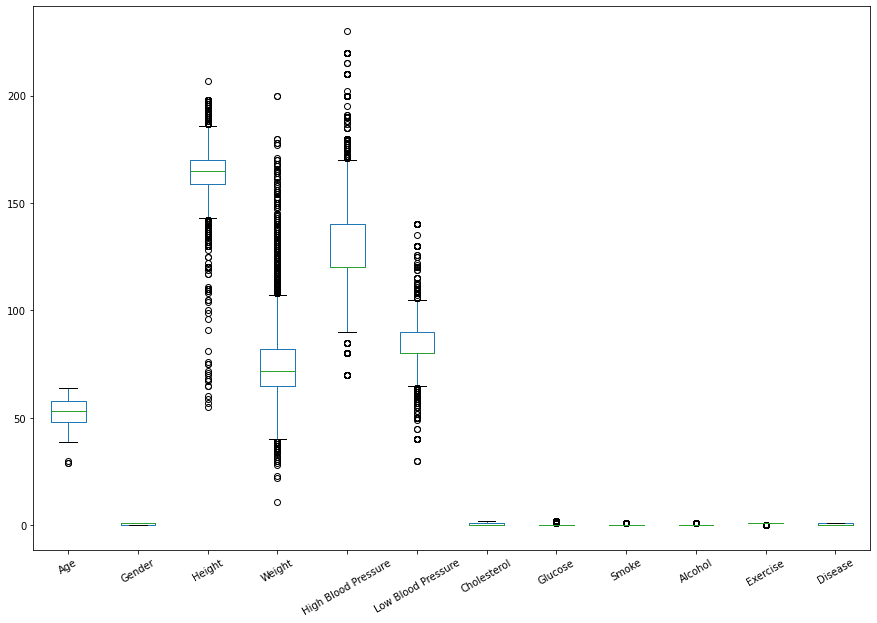

In [445]:
# plots to see the distribution of the data
df.boxplot(grid=False, rot=30, fontsize=10, figsize=(15,10))

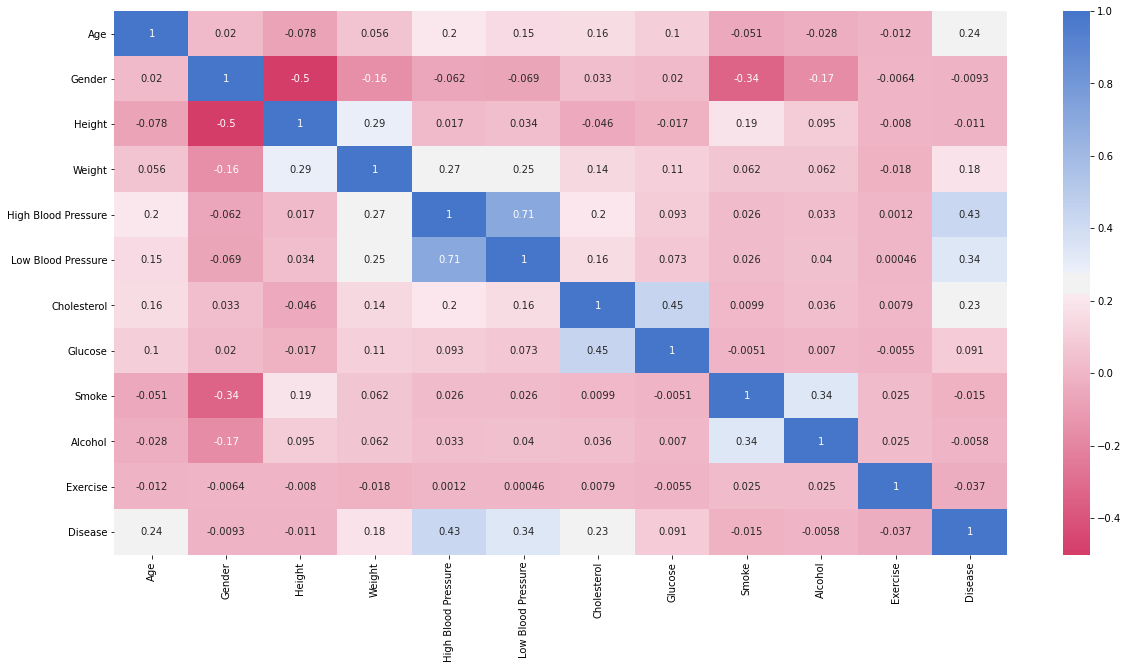

In [447]:
import matplotlib.pyplot as plt

# calculate correlation matrix (measures correlation between attributes and target variable)
corrMatrix = df.corr()
plt.subplots(figsize=(20,10))
cmap = sns.diverging_palette(0,255,sep=10, as_cmap=True)
sns.heatmap(corrMatrix, xticklabels=corrMatrix.columns, yticklabels=corrMatrix.columns, annot=True, cmap=cmap)

With the cleaned up data, we can plot a correlation matrix to see which attributes are the most closely linked to our target variable. We can see from the above correlation matrix that some columns in our data set have a positive correlation with the target variable (Disease). The most obvious of these columns are the blood pressure columns, Age, Cholesterol and Weight. This is understandable as having a high value for each of those attributes usually increases the chances of certain diseases. Conversly, exercise seems to have the largest negative correlation to disease, which makes sense since exercise is usually associated with being healthy.

We can now pre-process the data set so that our models can be trained better. We will normalize it so that all attributes have values between 0 and 1. 

In [401]:
# scale all the data we have so it's between the 0 and 1 range
from sklearn import preprocessing
df_minmax = preprocessing.MinMaxScaler().fit(df)
df = pd.DataFrame(df_minmax.transform(df), index=df.index, columns=df.columns)
df_normalized = pd.DataFrame(df, columns=df.columns, index=df.index)
df_normalized.describe()

,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease
count,48131.000000,48131.000000,48131.000000,48131.000000,48131.000000,48131.000000,48131.000000,48131.000000,48131.000000,48131.000000,48131.000000,48131.000000
mean,0.681281,0.651306,0.719543,0.333881,0.353956,0.466853,0.182492,0.112973,0.088155,0.054019,0.802851,0.495253
std,0.193243,0.476562,0.053851,0.075442,0.104363,0.087035,0.339389,0.286004,0.283523,0.226058,0.397850,0.499983
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.542857,0.000000,0.684211,0.285714,0.312500,0.454545,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.685714,1.000000,0.723684,0.322751,0.312500,0.454545,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.828571,1.000000,0.756579,0.375661,0.437500,0.545455,0.500000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Building machine learning algorithms

In order to build the algorithms, we are going to split the training data into a train-test split.

In [402]:
from sklearn.model_selection import train_test_split
# assign all but last data columns to X and the last (Disease) to y since that is our target
X = df_normalized.iloc[:, :-1].values
y = df_normalized.iloc[:, -1].values

# create train-test split for the data we have to train and tune models
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 1234)

### NBC

For NBC, there is only one parameter that we need to tune. So, we can use GridSearchCV to do that. GridSearchCV takes all the possible paramater permutations provided and iterates through them, outputting the one that is best suited to train the model. This way, we can be sure that the parameters are tuned so that our model is accurate.

Once we the best paramater configuration for this classifier, we can then use that to predict the test split of the training data and compare that to the actual target variable values in order to generate the f1 and accuracy scores. We will use these scores later to compare the different models that we have built.

In [429]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

# find best parameters for NBC
params_nbc = {'var_smoothing': np.logspace(0,-9, num=100)}
nbc = GridSearchCV(GaussianNB(),params_nbc, n_jobs=-1)

# train the model we generated
nbc.fit(x_train,y_train)
nbc.best_params_

{'var_smoothing': 1e-05}

In [404]:
# get predictions for the test set
nbc_prediction = nbc.predict(x_test)

# calculate the accuracy and f1 scores
nbc_accuracy_score = accuracy_score(y_test,nbc_prediction)
nbc_f1_score = f1_score(y_test, nbc_prediction)

# output the confusion matrix and the classification report
print("\033[1mConfusion Matrix\033[0m\n")
print(confusion_matrix(y_test, nbc_prediction))
print("\n\033[1mClassification Report\033[0m\n")
print(classification_report(y_test, nbc_prediction))

Confusion Matrix

[[5939 1344]
 [2840 4317]]

Classification Report

              precision    recall  f1-score   support

         0.0       0.68      0.82      0.74      7283
         1.0       0.76      0.60      0.67      7157

    accuracy                           0.71     14440
   macro avg       0.72      0.71      0.71     14440
weighted avg       0.72      0.71      0.71     14440



For NBC, we were able to achieve an accuracy score of 0.71 and an f1 score of 0.67.

### KNN

For KNN, there are two parameters that we need to tune. So, we can again leverage GridSearchCV to do that. We provided a range of 1-10 for the number of neighbors and 1,2 and 5 for the p parameter. The best configuration that GridSearchCV returned was:
* n_neighbors: 9
* p: 1

In [405]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# find best parameters for KNN
params_knn = {'n_neighbors': np.arange(1, 10), 'p': [1, 2, 5]}
knn = GridSearchCV(KNeighborsClassifier(),params_knn, n_jobs=-1)

# train the model we generated
knn.fit(x_train,y_train)
knn.best_params_

{'n_neighbors': 9, 'p': 1}

In [408]:
# get predictions for the test set
knn_prediction = knn.predict(x_test)

# calculate the accuracy and f1 scores
knn_accuracy_score = accuracy_score(y_test,knn_prediction)
knn_f1_score = f1_score(y_test, knn_prediction)

# output the confusion matrix and the classification report
print("\033[1mConfusion Matrix\033[0m\n")
print(confusion_matrix(y_test, knn_prediction))
print("\n\033[1mClassification Report\033[0m\n")
print(classification_report(y_test, knn_prediction))

Confusion Matrix

[[5367 1916]
 [2211 4946]]

Classification Report

              precision    recall  f1-score   support

         0.0       0.71      0.74      0.72      7283
         1.0       0.72      0.69      0.71      7157

    accuracy                           0.71     14440
   macro avg       0.71      0.71      0.71     14440
weighted avg       0.71      0.71      0.71     14440



For KNN, we were able to achieve an accuracy score of 0.71 and an f1 score of 0.71.

### Random Forest

For Random forest, there are various parameters that we can tune in order to get the best configuration for our model. However, running an exhaustive GridSearchCV is too computationally expensive and so instead RandomizedSearchCV can be used to focus in on the best configuration. RandomizedSearchCV takes in a parameter n_iter, which determines how many configurations to sample before returning the result. Since there are a lot of configurations with the provided parameters below, 10 were sampled and the best was returned to use in our model.

In [407]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# find best parameters for Random Forest
params_rf = {
            'n_estimators': [400, 600, 800, 1000],
            'max_depth': [ 40, 50, 60, None],
            'min_samples_split': [2, 5, 10, 15],
            'min_samples_leaf': [2, 4, 7, 11],
            'max_features': ['auto', 'sqrt', 'log2'],
            'bootstrap': [True, False]}
rf = RandomizedSearchCV(RandomForestClassifier(),params_rf, n_iter = 10, n_jobs=-1)

# train the model we generated
rf.fit(x_train,y_train)
rf.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 11,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': True}

In [409]:
# get predictions for the test set
rf_prediction = rf.predict(x_test)

# calculate the accuracy and f1 scores
rf_accuracy_score = accuracy_score(y_test,rf_prediction)
rf_f1_score = f1_score(y_test, rf_prediction)

# output the confusion matrix and the classification report
print("\033[1mConfusion Matrix\033[0m\n")
print(confusion_matrix(y_test, rf_prediction))
print("\n\033[1mClassification Report\033[0m\n")
print(classification_report(y_test, rf_prediction))

Confusion Matrix

[[5657 1626]
 [2178 4979]]

Classification Report

              precision    recall  f1-score   support

         0.0       0.72      0.78      0.75      7283
         1.0       0.75      0.70      0.72      7157

    accuracy                           0.74     14440
   macro avg       0.74      0.74      0.74     14440
weighted avg       0.74      0.74      0.74     14440



For Random forest, we were able to achieve an accuracy score of 0.74 and an f1 score of 0.72.

### Gradient Boosting Machine

For Gradient boosting machine, there are various parameters that we can tune in order to get the best configuration for our model. So, like with random forest, RandomizedSearchCV can be used to focus in on the best configuration. A sample size of 10 was chosen again in order to compute the best configuration.

In [433]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# find best parameters for Gradient Boosting
params_gb = {'learning_rate': [0.1, 0.5, 1],
            'n_estimators': [50, 100, 200, 500],
            'max_features': ['sqrt', 'log2']}
gb = RandomizedSearchCV(GradientBoostingClassifier(), params_gb, n_iter=10, n_jobs=-1)

# train the model we generated
gb.fit(x_train,y_train)
gb.best_params_

{'n_estimators': 200, 'max_features': 'sqrt', 'learning_rate': 0.1}

In [434]:
# get predictions for the test set
gb_prediction = gb.predict(x_test)

# calculate the accuracy and f1 scores
gb_accuracy_score = accuracy_score(y_test,gb_prediction)
gb_f1_score = f1_score(y_test, gb_prediction)

# output the confusion matrix and the classification report
print("\033[1mConfusion Matrix\033[0m\n")
print(confusion_matrix(y_test, gb_prediction))
print("\n\033[1mClassification Report\033[0m\n")
print(classification_report(y_test, gb_prediction))

Confusion Matrix

[[5663 1620]
 [2212 4945]]

Classification Report

              precision    recall  f1-score   support

         0.0       0.72      0.78      0.75      7283
         1.0       0.75      0.69      0.72      7157

    accuracy                           0.73     14440
   macro avg       0.74      0.73      0.73     14440
weighted avg       0.74      0.73      0.73     14440



For Gradient boosting machine, we were able to achieve an accuracy score of 0.74 and an f1 score of 0.72.

### Conclusion

After collecting results from all the models as well as the accuracy and f1 scores, we can see how each of the models stack up. From the table and graphs below, we can see that Random forest had the highest scores for each, followed closely by Gradient boosting machine. Their scores were almost the same, coming in at 74% for accuracy and 72% for the f1 score. KNN and NBC were three percentage points off accuracy (71%), with NBC having the worst f1 score at 67%.

In [412]:
models_list = ['NBC', 'KNN', 'Random Forest', 'Gradient Boosting']
model_scores = [[nbc_accuracy_score, nbc_f1_score], [knn_accuracy_score, knn_f1_score], [rf_accuracy_score, rf_f1_score], [gb_accuracy_score, gb_f1_score]]
scores_table = pd.DataFrame(model_scores, columns=["Accuracy Score", "F1 Score"])
scores_table.index = models_list
scores_table

,Accuracy Score,F1 Score
NBC,0.710249,0.673584
KNN,0.714197,0.705614
Random Forest,0.736565,0.723587
Gradient Boosting,0.735803,0.720983


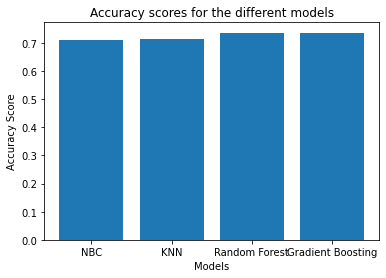

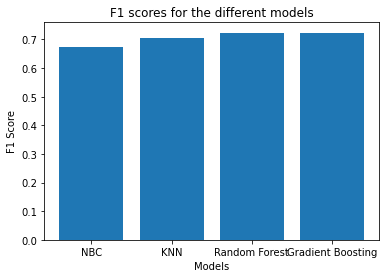

In [413]:
# accuracy score plot
plt.bar(models_list, [nbc_accuracy_score, knn_accuracy_score, rf_accuracy_score, gb_accuracy_score])
plt.title('Accuracy scores for the different models')
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.show()

# f1 score plot
plt.bar(models_list, [nbc_f1_score, knn_f1_score, rf_f1_score, gb_f1_score])
plt.title('F1 scores for the different models')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.show()
